In [ ]:
!git clone https://github.com/omriallouche/text_classification_from_zero_to_hero.git
import os
os.chdir('text_classification_from_zero_to_hero')

# ULMFiT
For more information I recommend this [excellent post](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb).

UlmFit consists of 3 steps:
1. Training the language model on a general-domain corpus that captures high-level natural language features
1. Fine-tuning the pre-trained language model on target task data
1. Fine-tuning the classifier on target task data

![ulmfit 3 steps](https://miro.medium.com/max/1616/1*w_qNXVr7N2OPCK5iMnHAVQ.png)

Step 1 requires a lot of resources and was already performed by the creators of the FastAI package. For this task we will perform steps 2 and 3.

It puts together a few tricks for optimizing neural networks:
1. Detection of initial Learning Rate. This is done by changing the learning rate in a wide range during the first steps of a neural network training, and keeping the rate that leads to the fastest decrease of the network loss. 
1. Cyclical learning rate changes, that aim to improve convergence speed while reducing the risk of getting stuck in a local minimum
1. Transfer learning 
1. Integration of a large unlabeled dataset. This dataset is used to fine-tune the language model
1. A rather simple but effective network architecture for the classifier. This NN architecture of 3 fully connected layers is supposed to provide solid performance on a large array of text classification tasks

Using Ulmfit is rather simple

The Note that we provide the data to the language model 
`bs` is the batch size.  
We use the function `learner.lr_find()` to find the learning rate.  

The function `learner.fit_one_cycle(PARAMETERS)` 


In [25]:
from fastai import *
from fastai.text import *

In [37]:
import pandas as pd
import os
df_trn = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/val.csv')
df_all = pd.read_csv('data/20newsgroups.csv')
df_trn.head()

,label,text,num_chars
0,talk.politics.mideast,i understand how israel captured the teritory ...,366
1,talk.politics.guns,and im sure that is a great comfort to the wid...,298
2,rec.sport.hockey,have a look at ed belfour. belfour kicked gerr...,288
3,talk.politics.mideast,deleted its noteworthy that the posts about th...,300
4,rec.sport.baseball,"recently, i heard the red sox on wrol a spanis...",365


In [30]:
batch_size = 16
path = '../models/'

In [31]:
df_trn = df_trn[['text', 'label']]
df_val = df_val[['text', 'label']]

# df_trn['text'] = df_trn['text'].str.split()
# df_val['text'] = df_val['text'].str.split()

## Fine-tuning a language model

In [32]:
# Language model data
print('Getting languge model data...')
if os.path.exists(path+'/'):
    data_lm = TextLMDataBunch.from_df(
        train_df=df_all, 
        path=path, 
        label_cols='label', 
        text_cols='text')
    data_lm.save('data_lm_export.pkl')
else:
    data_lm = load_data(path, 'data_lm_export.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
data_lm.show_batch()

idx,text
0,"rights . just wondering xxbos and i m sure that is a great xxunk to the xxunk and children of those xxunk , beaten and burned to death . the real question is , did the crime rate in england go down , after they xxunk gun control xxunk ? if you look at the rates before and after their first such law in , you will see no effect"
1,"the xxunk xxunk injury in the first or second game ? xxbos which article of the constitution gives me the right of xxunk if things seem to be going xxunk ? ? hmmm . xxunk xxunk white , president , xxunk inc . xxunk , xxunk , xxunk . xxunk xxbos you xxunk the part about xxunk it in a small shaped charge so that if anyone tries to xxunk"
2,"5 ! xxbos this post has all the earmarks of a form program , where the user types in a nationality or ethnicity and it fills it in in certain places in the story . if this is true , i condemn it . if its a fabrication , then the posters have horrible morals and should be despised by everyone on tpm who values truth . xxunk agreed ."
3,". , xxunk david vergolini writes . there s quite a few wings fans xxunk about here , they just tend to be low xxunk and xxunk rather than xxunk . i suppose every family must have a roger clinton , though . but remember to xxunk one of my xxunk star trek xxunk , if we xxunk the xxunk of the leaf fans , we are as bad as"
4,"answer , at least to what literature discussion news i ve seen .. xxbos i remember one he hit xxunk at xxunk field that went xxunk the street in dead center field and hit a house on the xxunk . he xxunk a lot , but when he did connect , watch out ! include xxunk xxbos xxunk played most of his xxunk career in seattle . he was one"


In [35]:
lm_learn = language_model_learner(
    data_lm, 
    drop_mult=0.7, 
    arch=AWD_LSTM)

# Change to float16 precision. This leads to x2-x3 speedup on modern GPUs
# lm_learn = lm_learn.to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


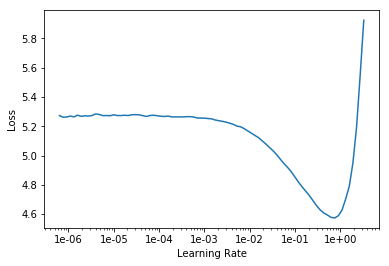

In [36]:
# Find the optimal learning rate
lm_learn.lr_find(start_lr=1e-07, end_lr=10)
# Plot a graph for detecting the optimal learning rate
lm_learn.recorder.plot()

We now can choose the learning rate from the plot above. 2e-1 seems to be a good value.

In [40]:
lr = 2e-1

In [ ]:
# train the learner object
lm_learn.fit_one_cycle(cyc_len=1, max_lr=lr)

We can test the language model by generating a few words following a seeding sentence:

In [39]:
lm_learn.predict("The problem with this is", n_words=20)

'The problem with this is are take not that are their are i this are i think are i i can this would their i'

In [38]:
lm_learn.unfreeze()
lm_learn.fit_one_cycle(cyc_len=10, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,18.679714,29.378891,0.018080,01:48


In [ ]:
lm_learn.predict("The problem with this is", n_words=20)

In [ ]:
# Save the model to disk. We will need it for the text classifier later
lm_learn.save_encoder('ft_enc')

## Training a classifier

In [34]:
if os.path.exists(path+'/data_clas.pkl'):
    data_clas = load_data(path, 'data_clas.pkl', bs=batch_size)
else:
    data_clas = TextClasDataBunch.from_df(
        path=path,
        train_df=df_trn, 
        valid_df=df_val,
        label_cols='label', 
        text_cols='text', 
        vocab=data_lm.train_ds.vocab, 
        bs=batch_size)    
    data_clas.save('data_clas.pkl')

In [ ]:
# 
classifier_learn = text_classifier_learner(data_clas, drop_mult=0.7, pretrained=False)
# 
classifier_learn.load_encoder('ft_enc')

In [ ]:
classifier_learn.lr_find()
classifier_learn.recorder.plot()

Let's set the learning rate based on the previous graph:

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

We'll now gradually unfreeze the layers, starting from the top layers and adding more layers every epoch:

In [ ]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

In [ ]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

In [ ]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

Finally, let's save our classifier:

In [ ]:
learn.save('ft_clas')

We can now make predictions:

In [ ]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)